In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import pydot

import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as k

In [2]:
#Helper functions...
def create_pairs(x, digit_indices):
    ''' Take an array of images and a list of lists, each internal list contains the indices of a class from the dataset
        return tow numpy arrays the first contains pairs of images, the second contains the equivalent labels of the pairs 
        if they were the same (1) or not (0)
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
#load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#prepare train and test set
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

#normalize the values
train_images = train_images/255.0
test_images = test_images/255.0

#create pairs of train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

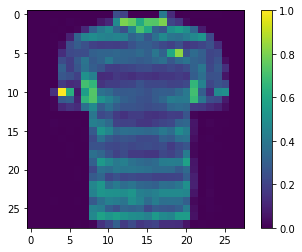

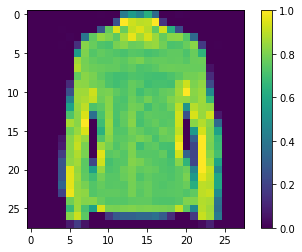

0.0


In [4]:
this_pair = 5

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(ts_y[this_pair])

In [5]:
#Building the model

#build the base model
def initializ_base_network():
    input = Input(shape = (28, 28), name = 'base_input')
    x = Flatten(name = 'flatten_input')(input)
    x = Dense(128, activation = 'relu', name = 'first_dense_layer')(x)
    x = Dropout(0.1, name = 'first_dropout')(x)
    x = Dense(128, activation = 'relu', name = 'second_dense_layer')(x)
    x = Dropout(0.1, name = 'second_dropout')(x)
    x = Dense(128, activation = 'relu', name = 'third_dense_layer')(x)
    return Model(inputs=input, outputs=x)


#calculat the euclidean distance
def euclidean_distance(vects):
    x, y = vects
    squared_sum = k.sum(k.square(x - y), axis = 1, keepdims = True)
    return k.sqrt(k.maximum(squared_sum, k.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return(shape1[0], 1)

In [6]:
# initializing a base network and visualize it
base_network = initializ_base_network()
plot_model(base_network, show_shapes = True, show_layer_names = True, to_file = 'base_network.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [7]:
#create the left input and point to the base network
input_a = Input(shape=(28, 28), name = 'left_input')
vect_output_a = base_network(input_a)

#create the right input and point to the base network
input_b = Input(shape=(28, 28), name='right_input')
vect_output_b = base_network(input_b)

#measure the similarity of the tow vectors
output = Lambda(euclidean_distance, name = 'output_layer', output_shape = eucl_dist_output_shape)([vect_output_a, vect_output_b])

#specify the inputs and outputs of the model
model = Model(inputs = [input_a, input_b], outputs = output)

#Visualize the final model
plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'final_model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [8]:
#define a custom loss function

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = k.square(y_pred)
        margin_squared = k.square(k.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_squared)
    return contrastive_loss

In [9]:
#build the model and train it 
rms = RMSprop()
model.compile(optimizer = rms, loss = contrastive_loss_with_margin(margin = 1))
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs = 20, batch_size = 128, validation_data = ([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 10s 10ms/step - loss: 0.1131 - val_loss: 0.0841
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0805 - val_loss: 0.0820
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0719 - val_loss: 0.0707
Epoch 4/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0661 - val_loss: 0.0756
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0632 - val_loss: 0.0676
Epoch 6/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0609 - val_loss: 0.0643
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0594 - val_loss: 0.0621
Epoch 8/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0578 - val_loss: 0.0655
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0572 - val_loss: 0.0637
Epoch 10/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0558 - val_loss: 0

In [10]:
#camputing accuracy
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [11]:
loss = model.evaluate([ts_pairs[:,0], ts_pairs[:,1]], ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {}, Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0637
Loss = 0.0636504739522934, Train Accuracy = 0.9385397566261043, Test Accuracy = 0.911011011011011


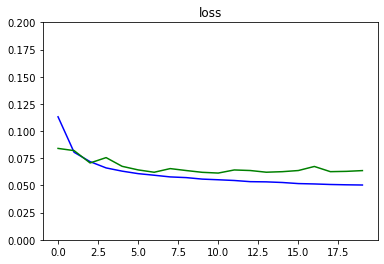

In [17]:
def plot_metrics(metric_name, title, ylim = 5):
    plt.plot(history.history[metric_name], color = 'blue', label = metric_name)
    plt.plot(history.history['val_' + metric_name], color = 'green', label = 'val' + metric_name)
    plt.ylim(0, ylim)
    plt.title(title)
    
plot_metrics('loss', 'Loss', 0.2)

In [18]:
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

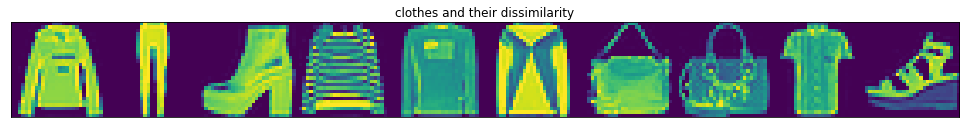

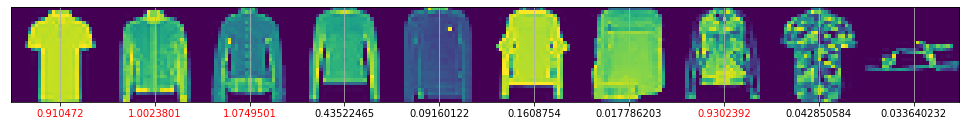

In [19]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)